# Mesh Workflow
The intention of this notebook is to create a new mesh workflow 
* Mesh generation in gmsh
* Mesh conversion with meshio to XDMF
* Reading mesh in dolfinx

The primary intention is to be able to mark/tag cells in gmsh with a string variable for further use in dolfinx. The tagged cells would be used to apply boundary condition, loads or material properties to different parts of the mesh.

In dolfinx we use `MeshFunction` to mark different parts of the mesh with boolean values, doubles or integers. So we need a way to transition from the string tags of gmsh to integers in dolfinx. For this we plan to use dictionaries.

We have created a mock `XDMF` file that contains the `field_data` inside `<Information>` tag. The actual number tags are stored in data2 table of `h5` HDF5 file. The intention here is to use that infromation to work with subdomains in a more intuitive way. The domain is a unit square with boundaries marked with name *[bottom, top, left, right]*

## Step 1: Creation of mesh from XDMF

In [1]:
import dolfin
import dolfin.io
import dolfin.plotting as plt
%matplotlib inline

In [2]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world,"Models/tag_triangle.xdmf") as xdmf_infile:
    mesh_2d = xdmf_infile.read_mesh(dolfin.MPI.comm_world, dolfin.cpp.mesh.GhostMode.none)

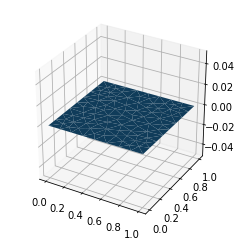

In [3]:
plt.plot(mesh_2d)

## Step 2: Reading domain tags to MVC


In [4]:
domain_mvc = dolfin.MeshValueCollection("size_t", mesh_2d, 2) #The mesh entity dimension for the mesh value collection.

In [5]:
# print("Constructing MeshFunction from MeshValueCollection")
domain_mf = dolfin.cpp.mesh.MeshFunctionSizet(mesh_2d, domain_mvc, 0) # 0=default value for mf

## Step 2: Reading all boundary tags to MVC

In [6]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world,"Models/tag_all.xdmf") as xdmf_infile:
    boundary_mvc = xdmf_infile.read_mvc_size_t(mesh_2d,"all_tags")

In [8]:
# print("Constructing MeshFunction from MeshValueCollection")
boundary_mf = dolfin.cpp.mesh.MeshFunctionSizet(mesh_2d, boundary_mvc, 0) # 0=default value for mf

In [35]:
from lxml import etree

with open(r'Models/tag_all.xdmf') as fobj:
        xml = fobj.read()
root = etree.fromstring(xml)

for domain in root.getchildren():
        for elem in domain.getchildren():
            if elem.tag=='Information':
                cdata = etree.fromstring(elem.text)

tags_dict = {}
for main in cdata.getchildren():
        tags_dict[main.values()[0]]=int(main.text)

In [36]:
tags_dict

{'bottom': 1, 'top': 2, 'left': 3, 'right': 4}

In [38]:
class Tags:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

In [39]:
tags=Tags(tags_dict)

## Step 4: Accessing subdomains from tag_dict

## Step 3: Creating tag dictionary from XDMF

In [37]:
tags_dict['bottom']

1

In [41]:
tags.bottom

1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 0, 3, 0, 4, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)

{(33, 1): 2,
 (34, 1): 1,
 (35, 1): 3,
 (36, 1): 4,
 (37, 1): 1,
 (38, 1): 2,
 (39, 1): 3,
 (40, 1): 4,
 (74, 1): 1,
 (75, 1): 2,
 (76, 1): 4,
 (77, 1): 3,
 (82, 1): 3,
 (83, 1): 4,
 (84, 1): 2,
 (85, 1): 2,
 (86, 1): 1,
 (87, 1): 1,
 (88, 1): 3,
 (89, 1): 4,
 (103, 1): 2,
 (104, 1): 1,
 (105, 1): 3,
 (106, 1): 4,
 (108, 1): 1,
 (109, 1): 2,
 (110, 1): 3,
 (111, 1): 4,
 (112, 1): 1,
 (113, 1): 2,
 (114, 1): 3,
 (115, 1): 4}